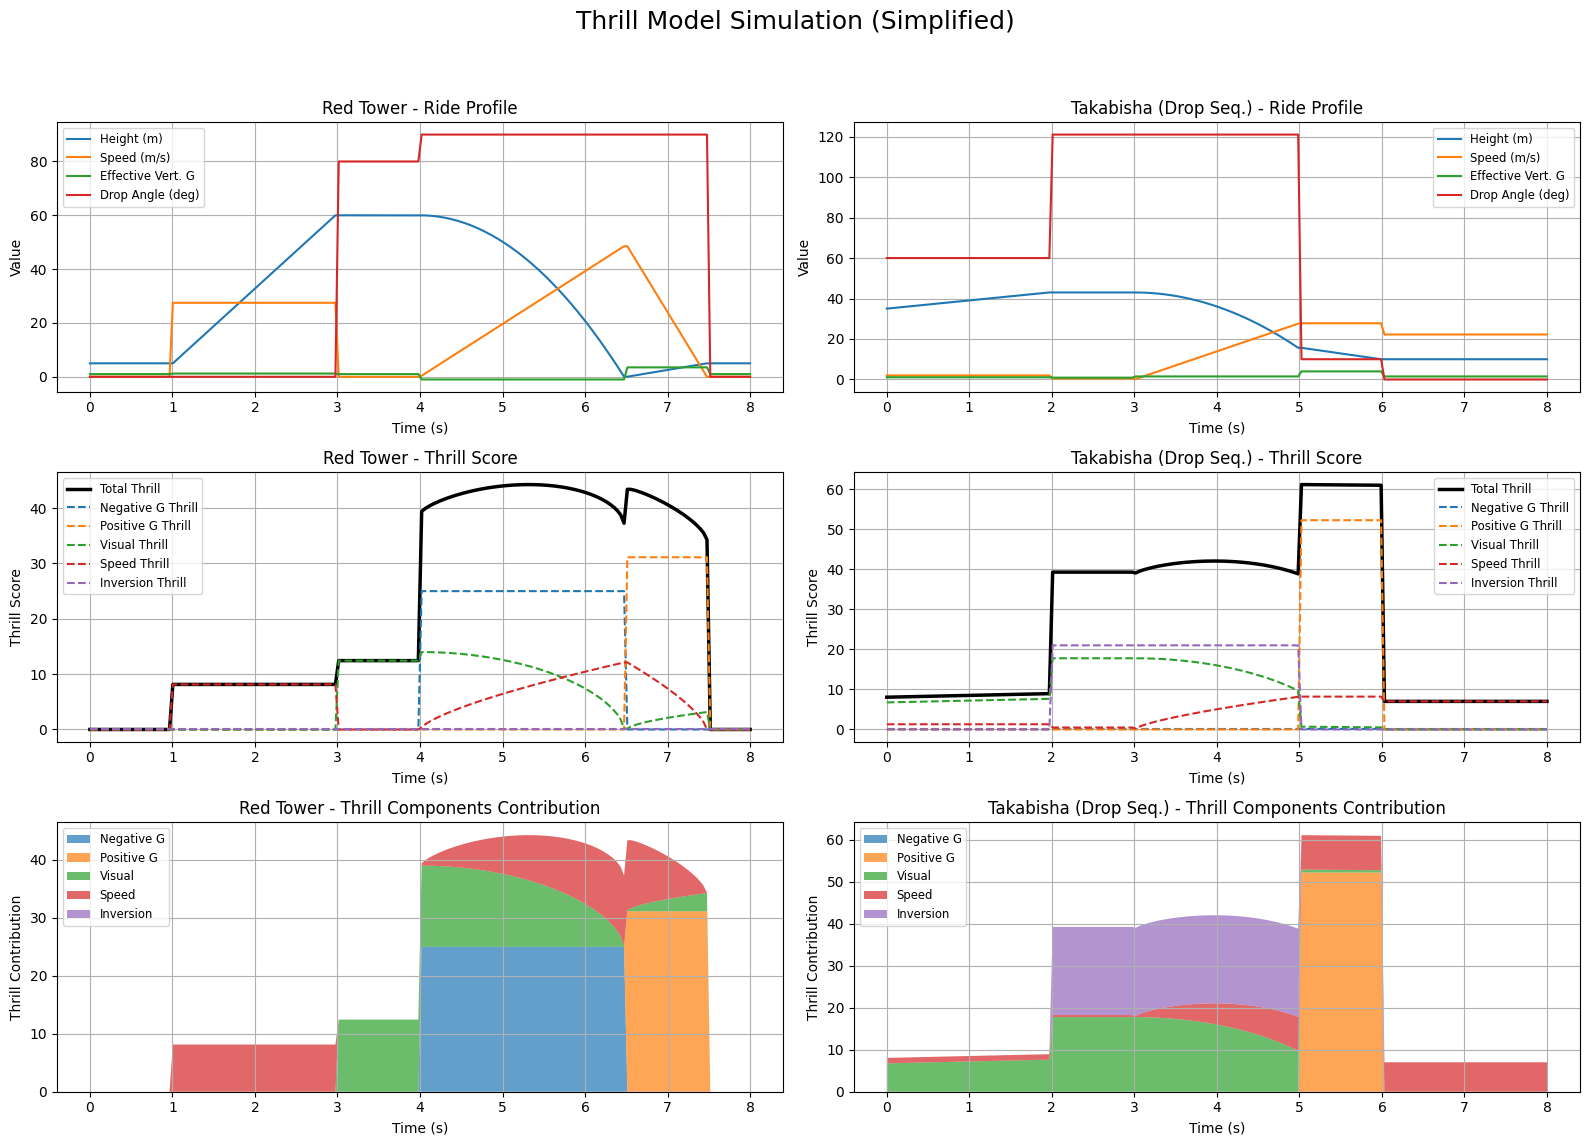

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- スリルモデル関数 ---
def angle_factor_func(theta_drop_deg):
    """落下角度に応じて視覚スリルへの影響係数を返す関数"""
    if theta_drop_deg < 0: return 0.0
    if theta_drop_deg <= 45:
        return (theta_drop_deg / 45.0) * 0.5
    elif theta_drop_deg <= 90:
        return 0.5 + ((theta_drop_deg - 45.0) / 45.0) * 0.5
    elif theta_drop_deg <= 135: # 90度超えをさらに強調
        return 1.0 + ((theta_drop_deg - 90.0) / 45.0) * 0.8 
    else:
        return 1.8 # 上限

def thrill_model(H, V, A_eff_vert, theta_drop_deg, is_inverted, params):
    """
    スリルスコアを計算する関数。
    H: 高度 (m)
    V: 速度 (m/s)
    A_eff_vert: 体感垂直G (1Gが通常、0Gが自由落下、-1Gは1G分の浮遊感)
    theta_drop_deg: 進行方向の落下角度 (度、水平0、垂直90、えぐり>90)
    is_inverted: 逆さま状態 (0 or 1)
    params: モデルのパラメータ辞書
    """
    s_neg_g = params['w_negG'] * np.maximum(0, -A_eff_vert)**params['p_negG']
    s_pos_g = params['w_posG'] * np.maximum(0, A_eff_vert - params['G_threshold_pos'])**params['p_posG']
    
    angle_f = angle_factor_func(theta_drop_deg)
    s_visual = params['w_height'] * np.maximum(0,H)**params['p_height'] * angle_f
    
    s_speed = params['w_speed'] * np.maximum(0,V)**params['p_speed']
    s_inversion = params['w_inv'] * is_inverted
    
    total_thrill = s_neg_g + s_pos_g + s_visual + s_speed + s_inversion
    
    components = {
        "Negative G": s_neg_g, "Positive G": s_pos_g, 
        "Visual": s_visual, "Speed": s_speed, 
        "Inversion": s_inversion
    }
    return total_thrill, components

# --- モデルパラメータ (調整可能) ---
params = {
    'w_negG': 25, 'p_negG': 1.5,
    'w_posG': 15, 'p_posG': 1.8, 'G_threshold_pos': 2.0, # 2G超でスリルを感じ始めると仮定
    'w_height': 1.2, 'p_height': 0.6,
    'w_speed': 0.8, 'p_speed': 0.7,
    'w_inv': 30,
}

# --- ライドデータの簡易シミュレーション ---
# 時間軸
T_max = 8
N_points = 200
T = np.linspace(0, T_max, N_points)

# データ格納用配列初期化
def init_ride_data(num_points):
    return {
        'H': np.zeros(num_points), 'V': np.zeros(num_points),
        'A_eff_vert': np.ones(num_points), 'theta_drop': np.zeros(num_points),
        'is_inverted': np.zeros(num_points)
    }

# --- レッドタワー (簡易シナリオ) ---
rt_data = init_ride_data(N_points)
# 0-1s: 静止・準備
rt_data['H'][T <= 1] = 5 # 地上より少し高い位置
# 1-3s: 上昇 (60mまで2秒で。実際はもっとゆっくり)
ascent_mask_rt = (T > 1) & (T <= 3)
rt_data['H'][ascent_mask_rt] = np.linspace(5, 60, np.sum(ascent_mask_rt))
rt_data['V'][ascent_mask_rt] = (60-5)/2
rt_data['A_eff_vert'][ascent_mask_rt] = 1.2 # 軽い加速G
# 3-4s: 頂上停止
summit_mask_rt = (T > 3) & (T <= 4)
rt_data['H'][summit_mask_rt] = 60
rt_data['V'][summit_mask_rt] = 0
rt_data['A_eff_vert'][summit_mask_rt] = 1.0
rt_data['theta_drop'][summit_mask_rt] = 80 # 落下直前、やや下向きの視界を仮定
# 4-6.5s: 自由落下 (または強制落下 -1G)
drop_duration_rt = 2.5
drop_mask_rt = (T > 4) & (T <= 4 + drop_duration_rt)
t_in_drop_rt = T[drop_mask_rt] - 4
# 強制落下で-1G (体感) = 全体で2gの加速度で落下
drop_accel_rt = 2.0 * 9.81 # m/s^2
rt_data['H'][drop_mask_rt] = 60 - 0.5 * drop_accel_rt * t_in_drop_rt**2
rt_data['V'][drop_mask_rt] = drop_accel_rt * t_in_drop_rt
rt_data['A_eff_vert'][drop_mask_rt] = -1.0 # 体感-1G
rt_data['theta_drop'][drop_mask_rt] = 90 # 垂直落下
# 6.5-7.5s: 減速 (強い正G)
brake_mask_rt = (T > 4 + drop_duration_rt) & (T <= 4 + drop_duration_rt + 1.0)
rt_data['H'][brake_mask_rt] = np.linspace(rt_data['H'][drop_mask_rt][-1], 5, np.sum(brake_mask_rt)) # 地上近くまで減速
rt_data['V'][brake_mask_rt] = np.linspace(rt_data['V'][drop_mask_rt][-1], 0, np.sum(brake_mask_rt))
rt_data['A_eff_vert'][brake_mask_rt] = 3.5 # 強い減速G (仮定)
rt_data['theta_drop'][brake_mask_rt] = 90 # 減速中も下向き
# 7.5s-: 停止
stop_mask_rt = T > 4 + drop_duration_rt + 1.0
rt_data['H'][stop_mask_rt] = 5
rt_data['V'][stop_mask_rt] = 0
rt_data['A_eff_vert'][stop_mask_rt] = 1.0
rt_data['theta_drop'][stop_mask_rt] = 0

# --- 高飛車 (ドロップ部分の超簡易シナリオ) ---
tkb_data = init_ride_data(N_points)
# 0-2s: 巻き上げ後半～頂上付近 (高さ43m)
summit_approach_mask_tkb = (T >= 0) & (T <= 2)
tkb_data['H'][summit_approach_mask_tkb] = np.linspace(35, 43, np.sum(summit_approach_mask_tkb))
tkb_data['V'][summit_approach_mask_tkb] = 2.0 # 低速巻き上げ
tkb_data['A_eff_vert'][summit_approach_mask_tkb] = 1.1
tkb_data['theta_drop'][summit_approach_mask_tkb] = 60 # やや前傾
# 2-3s: ドロップ体勢ホールド (121度)
hold_mask_tkb = (T > 2) & (T <= 3)
tkb_data['H'][hold_mask_tkb] = 43
tkb_data['V'][hold_mask_tkb] = 0.5 # ほぼ停止
tkb_data['A_eff_vert'][hold_mask_tkb] = 0.9 # 少し吊り下げられる感じ
tkb_data['theta_drop'][hold_mask_tkb] = 121 
tkb_data['is_inverted'][hold_mask_tkb] = 0.7 # 121度はほぼ逆さまに近い感覚として表現
# 3-5s: 121度ドロップ (2秒で落下、速度100km/hへ)
drop_duration_tkb = 2.0
drop_mask_tkb = (T > 3) & (T <= 3 + drop_duration_tkb)
t_in_drop_tkb = T[drop_mask_tkb] - 3
V_final_tkb = 100 / 3.6 # m/s
drop_accel_tkb = V_final_tkb / drop_duration_tkb
# 121度落下時の体感Gは複雑。ここでは仮に進行方向への加速によるGと視覚効果を重視。
# 垂直成分の変位を考慮 (sin(121-90)では不正確。軌道による)
tkb_data['H'][drop_mask_tkb] = 43 - 0.5 * drop_accel_tkb * t_in_drop_tkb**2 * np.sin(np.deg2rad(121-30)) # 適当な垂直成分
tkb_data['V'][drop_mask_tkb] = drop_accel_tkb * t_in_drop_tkb
tkb_data['A_eff_vert'][drop_mask_tkb] = 1.5 # ドロップ中の体感G (押し付けられる要素もあると仮定)
tkb_data['theta_drop'][drop_mask_tkb] = 121
tkb_data['is_inverted'][drop_mask_tkb] = 0.7
# 5-6s: ドロップ後ボトム (速度最大、強い正G 4.4G)
bottom_mask_tkb = (T > 3 + drop_duration_tkb) & (T <= 3 + drop_duration_tkb + 1.0)
tkb_data['H'][bottom_mask_tkb] = np.linspace(tkb_data['H'][drop_mask_tkb][-1], 10, np.sum(bottom_mask_tkb))
tkb_data['V'][bottom_mask_tkb] = V_final_tkb
tkb_data['A_eff_vert'][bottom_mask_tkb] = 4.0 # 公称値に近い強いG (4.4Gは瞬間最大値の可能性)
tkb_data['theta_drop'][bottom_mask_tkb] = 10 # 水平に戻りつつある
tkb_data['is_inverted'][bottom_mask_tkb] = 0
# 6s-: 水平走行 (省略)
tkb_data['H'][T > 3 + drop_duration_tkb + 1.0] = 10
tkb_data['V'][T > 3 + drop_duration_tkb + 1.0] = V_final_tkb * 0.8 # やや減速
tkb_data['A_eff_vert'][T > 3 + drop_duration_tkb + 1.0] = 1.5
tkb_data['theta_drop'][T > 3 + drop_duration_tkb + 1.0] = 0

# --- スリル計算実行 ---
rides = {"Red Tower": rt_data, "Takabisha (Drop Seq.)": tkb_data}
thrills = {}
thrill_components_data = {}

for name, data in rides.items():
    total_thrill_scores = np.zeros(N_points)
    components_list = [{} for _ in range(N_points)]
    for i in range(N_points):
        total_thrill_scores[i], components_list[i] = thrill_model(
            data['H'][i], data['V'][i], data['A_eff_vert'][i],
            data['theta_drop'][i], data['is_inverted'][i], params
        )
    thrills[name] = total_thrill_scores
    
    # 要素ごとのスリル値を集計
    temp_components = {key: np.zeros(N_points) for key in params.keys() if key.startswith('w_')}
    # ちょっとキー名が違うので合わせる
    component_map = {"w_negG": "Negative G", "w_posG": "Positive G", "w_height":"Visual", "w_speed":"Speed", "w_inv":"Inversion"}
    organized_components = {label: np.zeros(N_points) for label in component_map.values()}

    for i, comp_dict_at_t in enumerate(components_list):
        for label in organized_components.keys():
            organized_components[label][i] = comp_dict_at_t.get(label,0)
    thrill_components_data[name] = organized_components


# --- 可視化 ---
num_rides = len(rides)
fig, axs = plt.subplots(3, num_rides, figsize=(8 * num_rides, 12), squeeze=False)
fig.suptitle("Thrill Model Simulation (Simplified)", fontsize=18)

for i, (name, data) in enumerate(rides.items()):
    # ライドプロファイル
    ax_profile = axs[0, i]
    ax_profile.plot(T, data['H'], label="Height (m)")
    ax_profile.plot(T, data['V'], label="Speed (m/s)")
    ax_profile.plot(T, data['A_eff_vert'], label="Effective Vert. G")
    ax_profile.plot(T, data['theta_drop'], label="Drop Angle (deg)")
    ax_profile.set_title(f"{name} - Ride Profile")
    ax_profile.set_xlabel("Time (s)")
    ax_profile.set_ylabel("Value")
    ax_profile.legend(fontsize='small')
    ax_profile.grid(True)

    # スリルスコア（合計と要素別）
    ax_thrill = axs[1, i]
    ax_thrill.plot(T, thrills[name], label="Total Thrill", color='black', linewidth=2.5)
    for component_name, scores in thrill_components_data[name].items():
        ax_thrill.plot(T, scores, label=f"{component_name} Thrill", linestyle='--')
    ax_thrill.set_title(f"{name} - Thrill Score")
    ax_thrill.set_xlabel("Time (s)")
    ax_thrill.set_ylabel("Thrill Score")
    ax_thrill.legend(fontsize='small')
    ax_thrill.grid(True)
    
    # スリル要素のスタックプロット
    ax_stack = axs[2, i]
    labels = list(thrill_components_data[name].keys())
    stack_data = [thrill_components_data[name][key] for key in labels]
    ax_stack.stackplot(T, stack_data, labels=labels, alpha=0.7)
    ax_stack.set_title(f"{name} - Thrill Components Contribution")
    ax_stack.set_xlabel("Time (s)")
    ax_stack.set_ylabel("Thrill Contribution")
    ax_stack.legend(fontsize='small', loc='upper left')
    ax_stack.grid(True)


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # タイトルとの重なりを調整
plt.show()